Using device: cuda
Loading model from ./mixtex_reproduce/checkpoint-72000...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading dataset...
Generating...

Ground Truth (真实标签):

 
 \(2\) 态类对称函数 \(\mathbf{J}\) 的泛函域结构。我们研究了相同框架中一般线性群的直角子群和 \(913\) 复数子群
 \[ 
\begin{aligned}(\omega+i\partial\bar\partial w)^{n+1}&=0\qquad\bar D\times X\\\omega+i\partial\bar\partial w|\{s\}\times X&>0 s\in\bar D,\end{aligned}
 \] 
的一般线性群。我们证明了  \(fV\) CSp 和 CSp 也具有与 CGL 相似的等价泛函域结构，并且具有与 CGL 相似 \(1\) 的算子结构。这些泛函域的定义与标准基有关，类似于对称函
 

------------------------------
Prediction (模型预测):
 
 \(\)态对称 \(\{}\)函数mathbfJ 的强结构我们研究了框架相一致旋转一般性的有理 \(13\)算子 \(13\)子群9\)子群 \[
omega i i \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 

/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31216 (\N{CJK UNIFIED IDEOGRAPH-79F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from fon

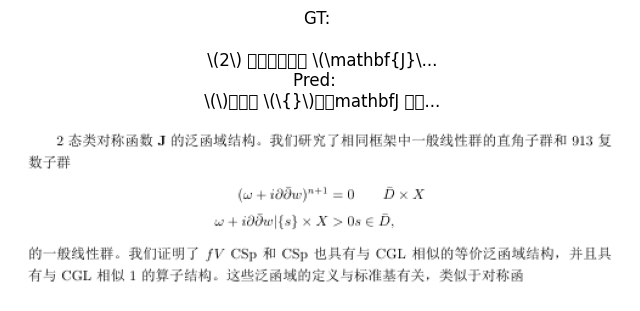

In [1]:
import torch
from modelscope import VisionEncoderDecoderModel, AutoTokenizer, AutoImageProcessor
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# =================配置区域=================
# 1. 指向你的 checkpoint 文件夹
CHECKPOINT_PATH = "./mixtex_reproduce/checkpoint-72000"

# 2. 图片尺寸（必须与训练时一致）
TARGET_HEIGHT = 416
TARGET_WIDTH = 512

# 3. 数据集路径
DATASET_FILE = "pseudo_latex_train.parquet" 
# =========================================

# --- 1. 重新定义 Image Processor (必须与训练代码一致) ---
class MixTexImageProcessor:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image: Image.Image):
        image = image.convert("RGB")
        iw, ih = image.size
        w, h = TARGET_WIDTH, TARGET_HEIGHT
        scale = min(w / iw, h / ih)
        nw = int(iw * scale)
        nh = int(ih * scale)
        image = image.resize((nw, nh), Image.BICUBIC)
        new_image = Image.new('RGB', (w, h), (255, 255, 255))
        paste_x = (w - nw) // 2
        paste_y = (h - nh) // 2
        new_image.paste(image, (paste_x, paste_y))
        tensor = self.to_tensor(new_image)
        tensor = transforms.functional.normalize(tensor, mean=self.mean, std=self.std)
        return tensor

def run_inference():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # --- 2. 加载模型和 Tokenizer ---
    print(f"Loading model from {CHECKPOINT_PATH}...")
    try:
        model = VisionEncoderDecoderModel.from_pretrained(CHECKPOINT_PATH).to(device)
        tokenizer = AutoTokenizer.from_pretrained("MixTeX/MixTex-ZhEn-Latex-OCR")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # 初始化 Processor
    swin_cfg = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
    image_processor = MixTexImageProcessor(mean=swin_cfg.image_mean, std=swin_cfg.image_std)

    # --- 3. 加载一条数据 ---
    print("Loading dataset...")
    # 这里只加载前几条，速度快
    dataset = load_dataset("parquet", data_files=DATASET_FILE, split="train[:10]")
    
    # 选一张图，比如第 0 张
    sample_idx = 0 
    sample = dataset[sample_idx]
    image = sample["image"]
    gt_text = sample["text"]

    # --- 4. 预处理 ---
    pixel_values = image_processor(image).unsqueeze(0).to(device) # [1, 3, 416, 512]

    # --- 5. 推理 (Generate) ---
    print("Generating...")
    model.eval()
    with torch.no_grad():
        # 使用 greedy search (num_beams=1) 方便调试，看看最原始输出
        generated_ids = model.generate(
            pixel_values,
            max_length=296,
            pad_token_id=tokenizer.pad_token_id,
            decoder_start_token_id=tokenizer.cls_token_id,
            eos_token_id=tokenizer.sep_token_id,
            num_beams=1, 
            do_sample=False, # 关闭采样，确保结果确定性
        )

    # --- 6. 解码 ---
    pred_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    raw_tokens = tokenizer.convert_ids_to_tokens(generated_ids[0])

    # --- 7. 打印结果分析 ---
    print("\n" + "="*30)
    print("Ground Truth (真实标签):")
    print(gt_text)
    print("-" * 30)
    print("Prediction (模型预测):")
    print(pred_text)
    print("-" * 30)
    print(f"Raw Token IDs (前20个): {generated_ids[0][:20].tolist()}")
    print("="*30)

    # --- 8. 可视化图片 ---
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"GT: {gt_text[:30]}...\nPred: {pred_text[:30]}...")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    run_inference()